In [14]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from statistics import median

In [15]:
def read_df(group_name, group_1, group_2, trans_metric, log=False, suffix = None):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)
    target_labels = list(target_equity_df['target_label'])
    target_pred_labels = list(target_equity_df['target_pred_label'])
    trans_target_pred_labels = list(target_equity_df['trans_target_pred_label'])
    if log:
        target_labels = [np.log(x) for x in target_labels]
        trans_target_pred_labels = [np.log(x) for x in trans_target_pred_labels]

    return target_labels, target_pred_labels, trans_target_pred_labels

In [16]:
def convert_sec2hour(x):
    factor = 60*60
    return x/factor

In [17]:
# group_name = 'marital_status'
# groups = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED']

group_name = 'insurance'
groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']
cmap = { 0:'k',1:'blue',2:'y',3:'g',4:'r' }
trans_metric = 'OT'
thresholds = [2*10**2, 3*10**2] 
thres = 3*10**2 # 300 hours


source is: Self_Pay, target is: Private


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]


/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


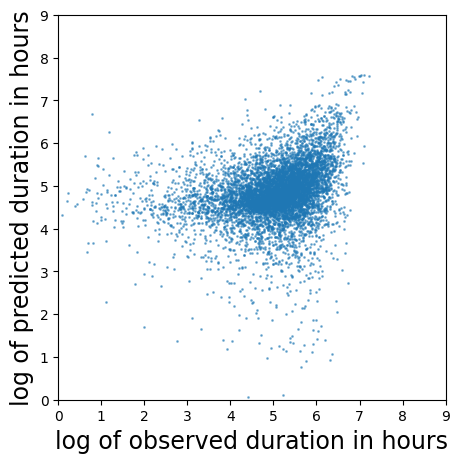

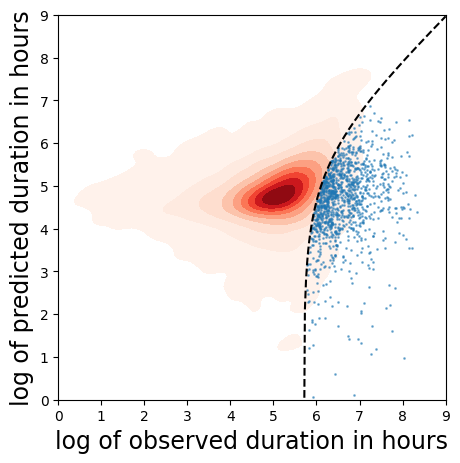

source is: Self_Pay, target is: Government


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


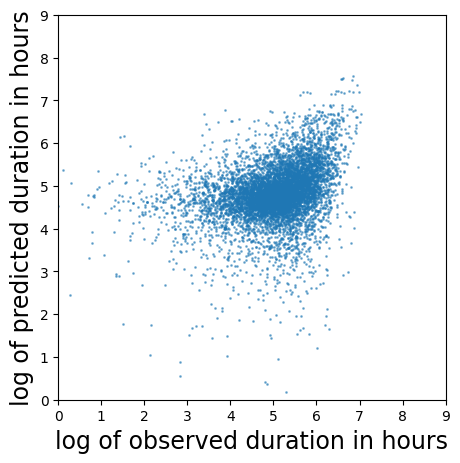

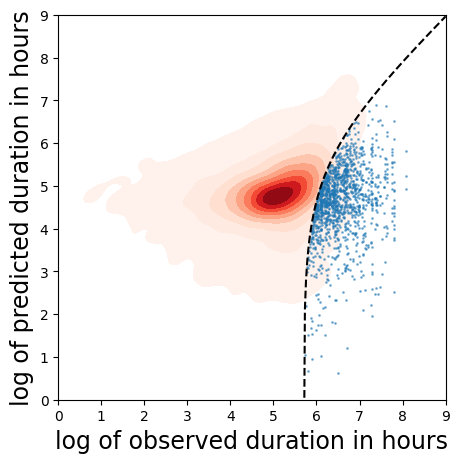

source is: Self_Pay, target is: Medicare


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


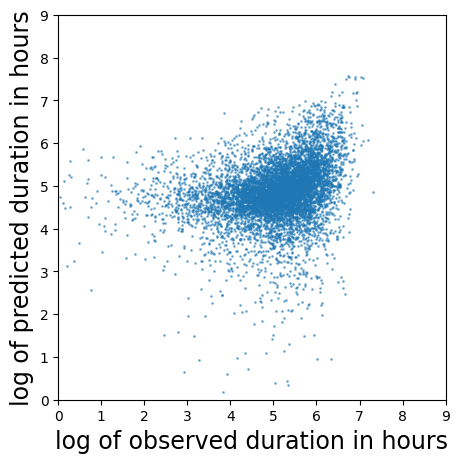

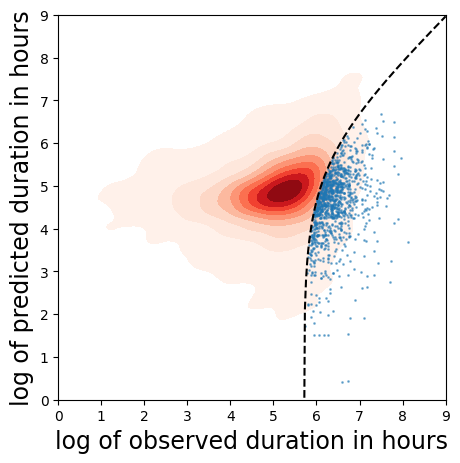

source is: Self_Pay, target is: Medicaid


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


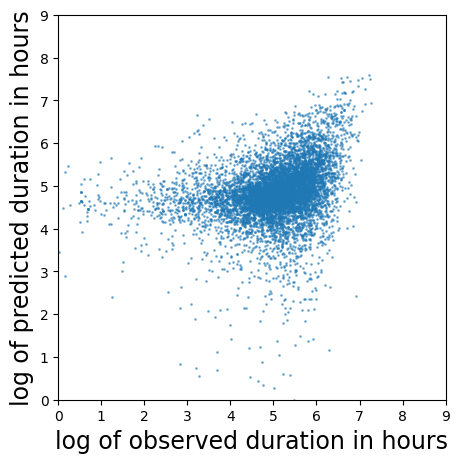

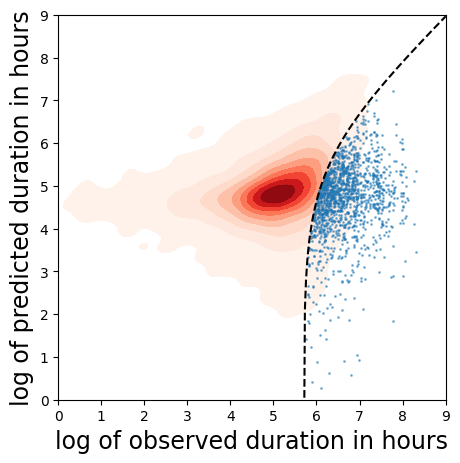

source is: Private, target is: Self_Pay


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


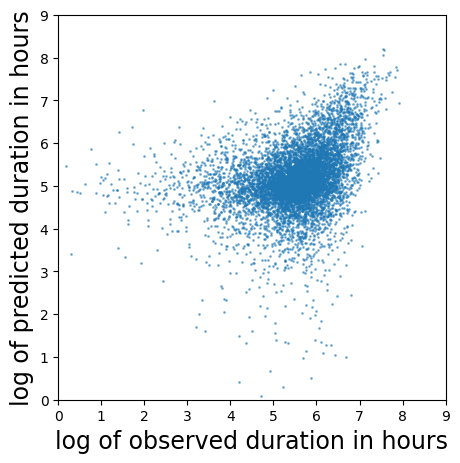

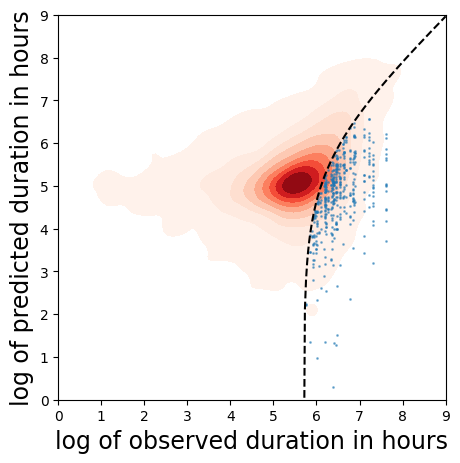

source is: Private, target is: Government


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


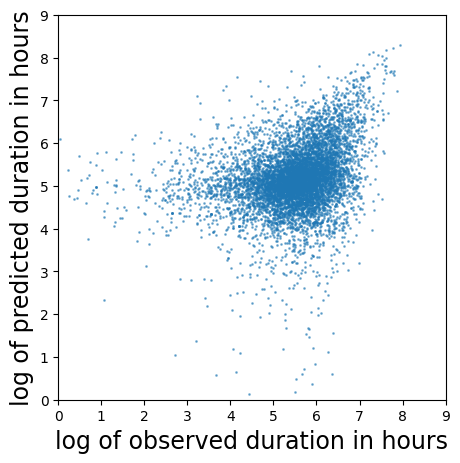

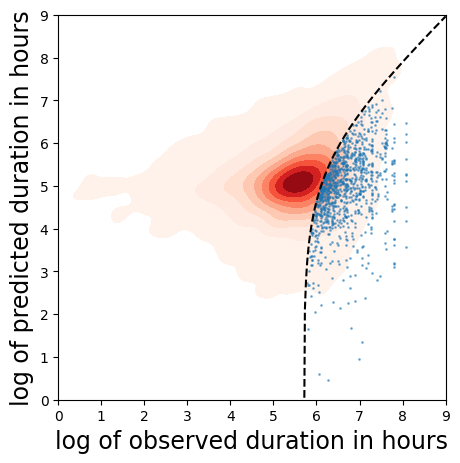

source is: Private, target is: Medicare


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


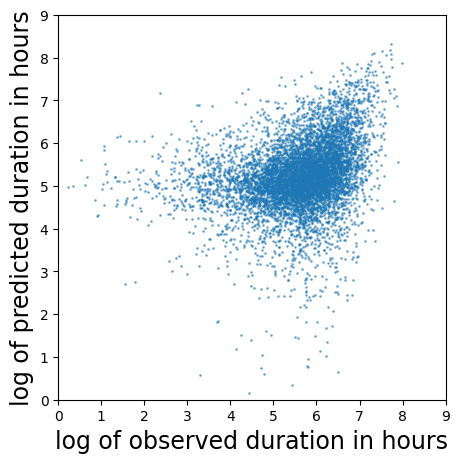

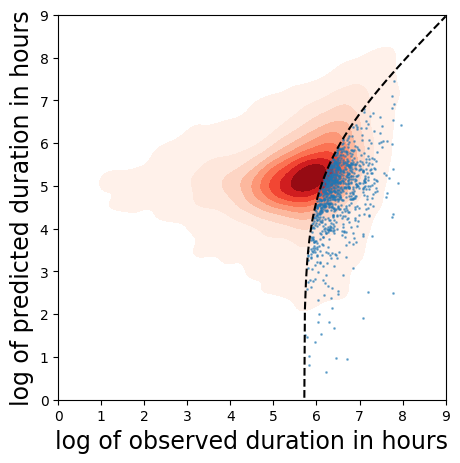

source is: Private, target is: Medicaid


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


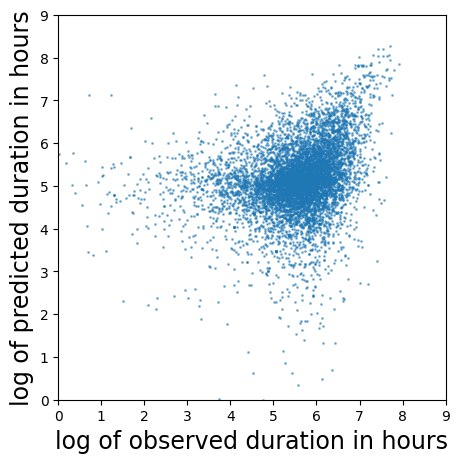

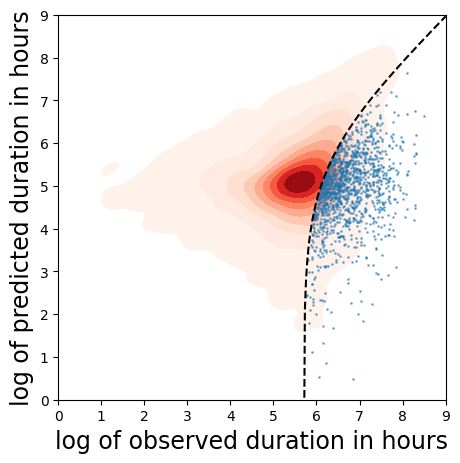

source is: Government, target is: Self_Pay


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


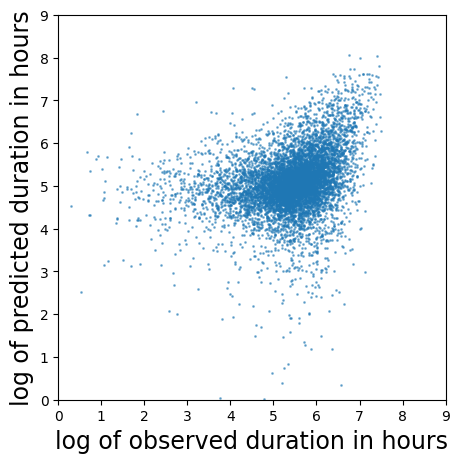

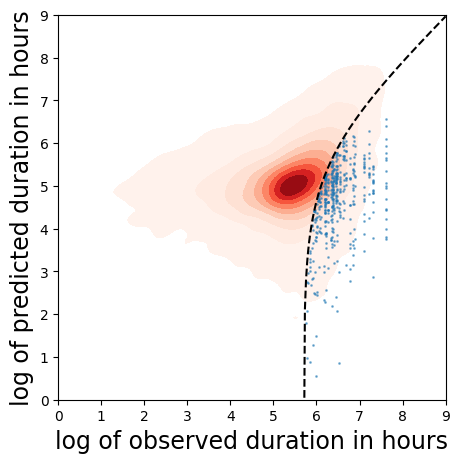

source is: Government, target is: Private


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


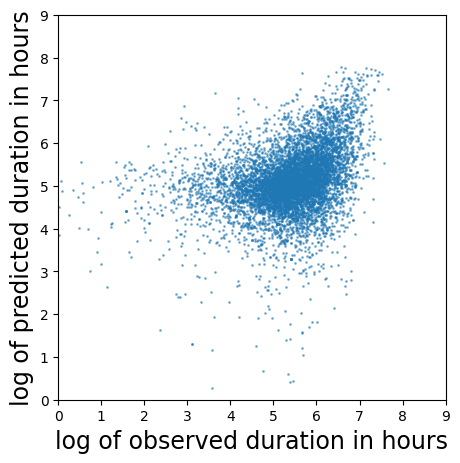

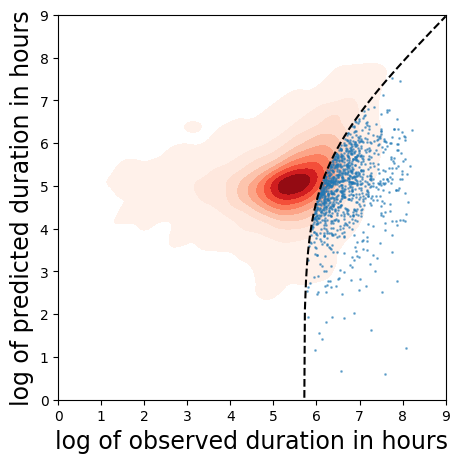

source is: Government, target is: Medicare


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


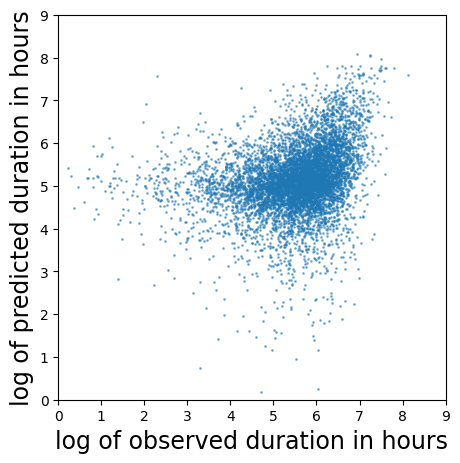

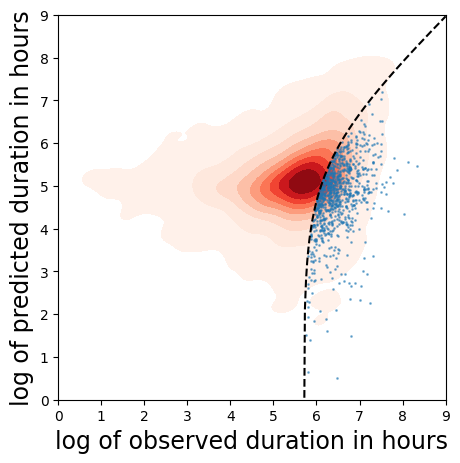

source is: Government, target is: Medicaid


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


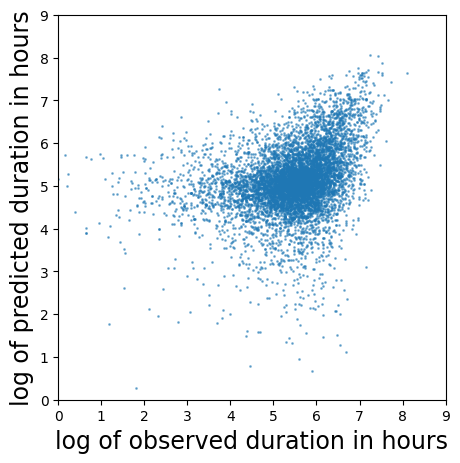

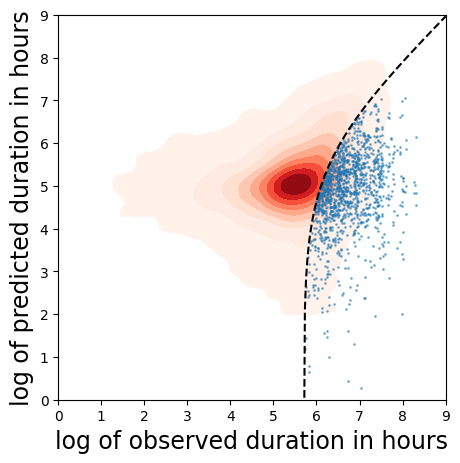

source is: Medicare, target is: Self_Pay


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


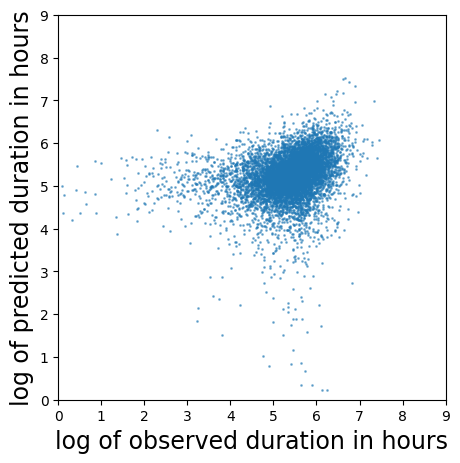

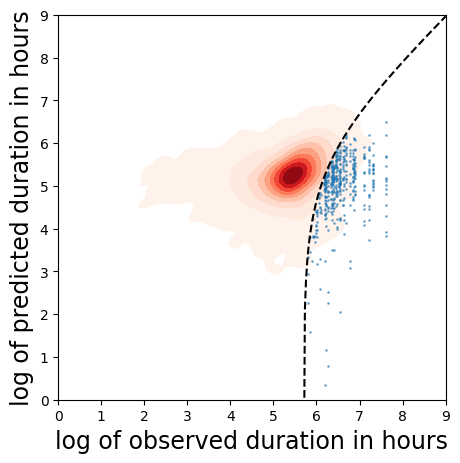

source is: Medicare, target is: Private


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


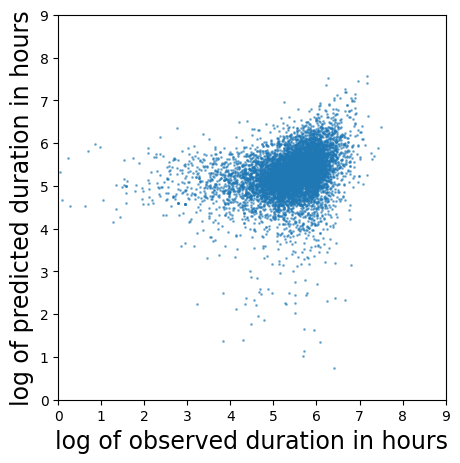

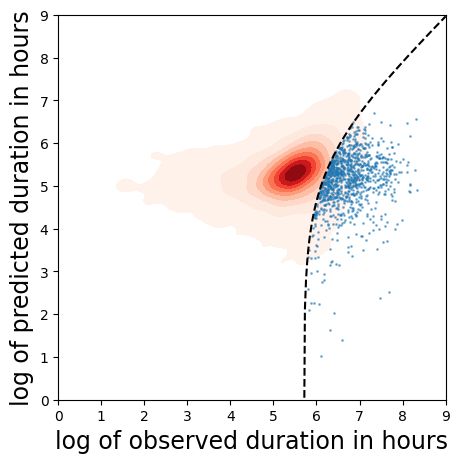

source is: Medicare, target is: Government


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


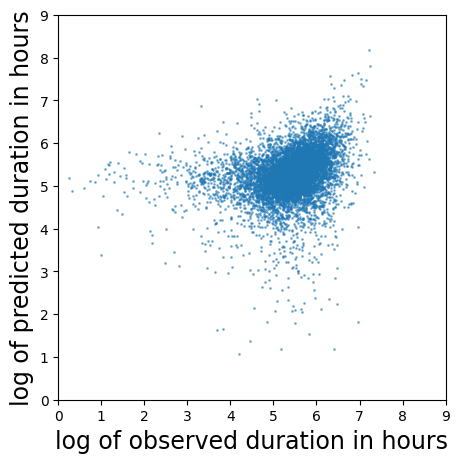

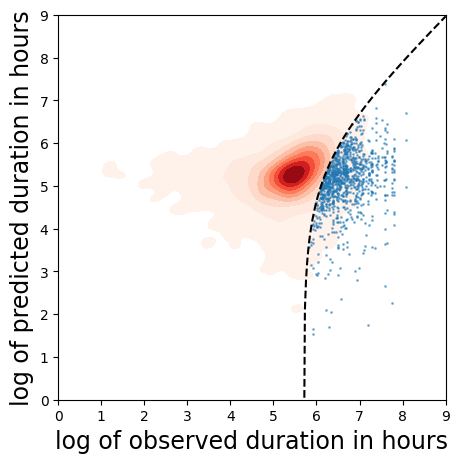

source is: Medicare, target is: Medicaid


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


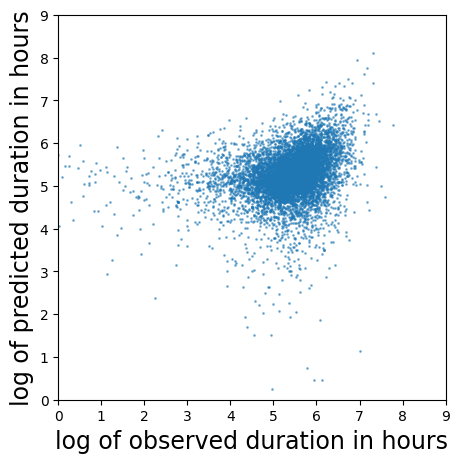

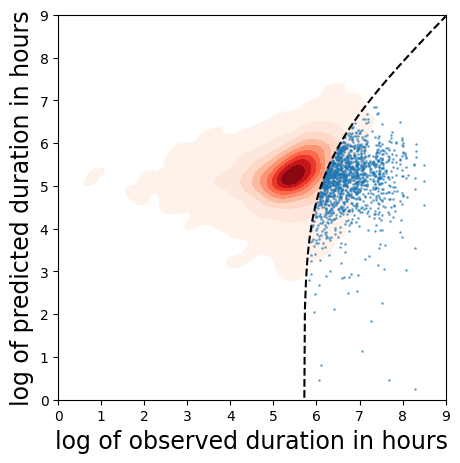

source is: Medicaid, target is: Self_Pay


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


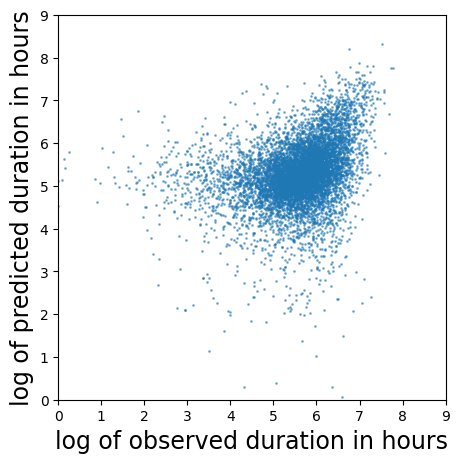

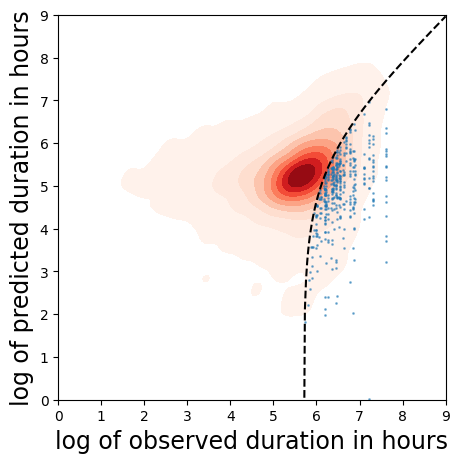

source is: Medicaid, target is: Private


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


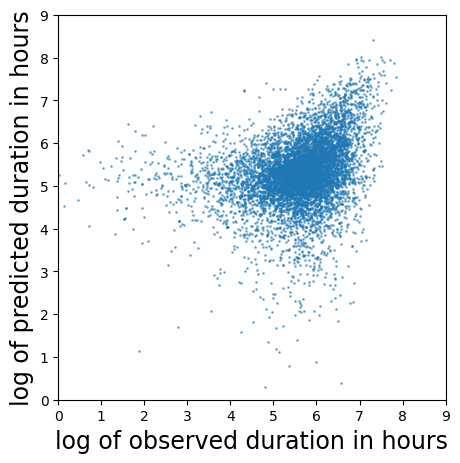

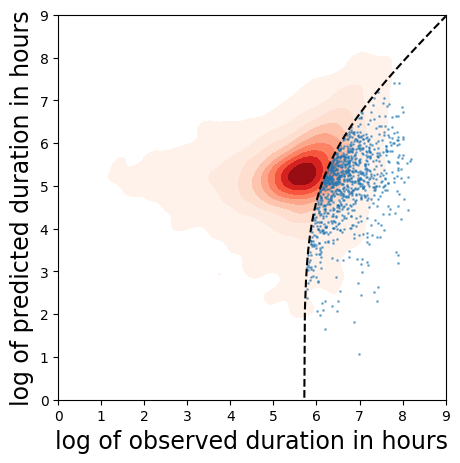

source is: Medicaid, target is: Government


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


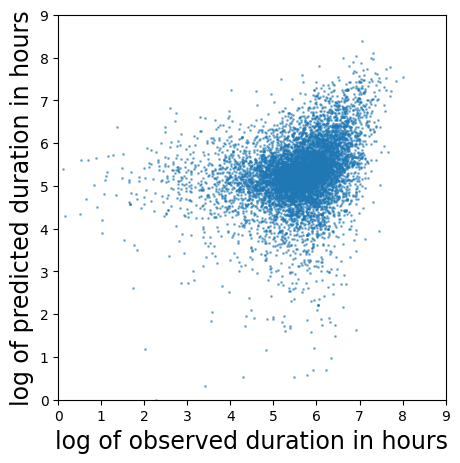

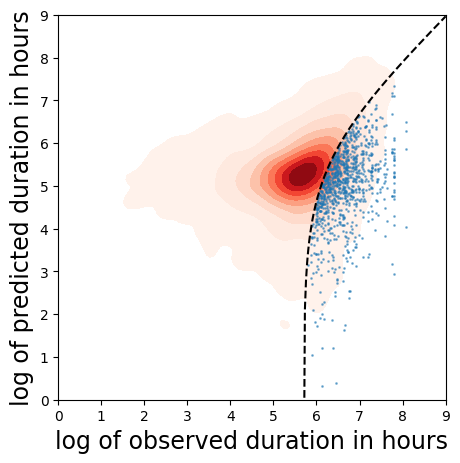

source is: Medicaid, target is: Medicare


/tmp/ipykernel_422321/1064424951.py:15: RuntimeWarning: invalid value encountered in log
  log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
/tmp/ipykernel_422321/1064424951.py:16: RuntimeWarning: invalid value encountered in log
  log_target_label = [np.log(x) for x in target_pred_label]
/tmp/ipykernel_422321/1064424951.py:54: RuntimeWarning: invalid value encountered in log
  plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
/tmp/ipykernel_422321/1064424951.py:59: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')


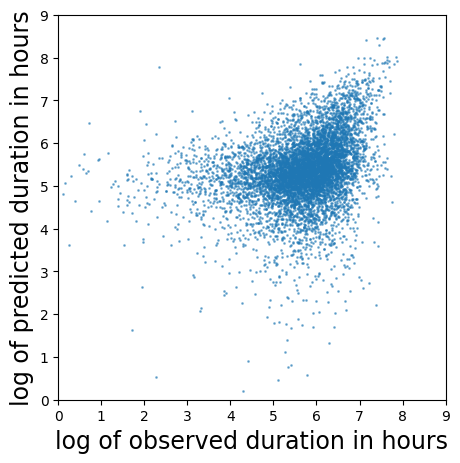

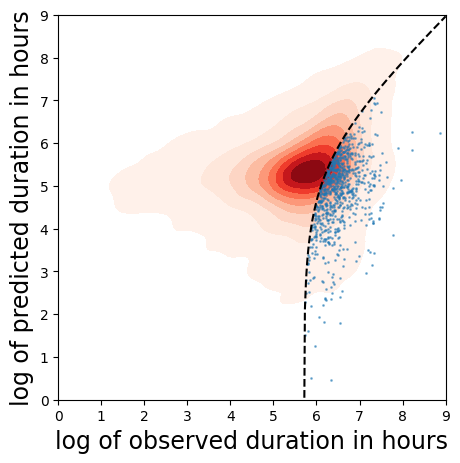

In [25]:
for source_group in groups:
    for target_group in groups:
        if source_group == target_group:
            continue
        # Plot scatter plot to show predicted duration vs observed duration
        plt.figure(figsize=(5,5))
        ax = plt.gca()

        print(f"source is: {source_group}, target is: {target_group}")

        target_label, target_pred_label, trans_target_pred_label = read_df(group_name, source_group, target_group, trans_metric, log=False)
        target_label = [convert_sec2hour(x) for x in target_label]
        target_pred_label = [convert_sec2hour(x) for x in target_pred_label]
        trans_target_pred_label = [convert_sec2hour(x) for x in trans_target_pred_label]
        log_trans_target_pred_label = [np.log(x) for x in trans_target_pred_label]
        log_target_label = [np.log(x) for x in target_pred_label]
        ax.scatter(log_target_label, log_trans_target_pred_label, s=1, alpha=0.5, c='tab:blue')


        ax.set_xlabel('log of observed duration in hours', fontsize=17)
        ax.set_ylabel('log of predicted duration in hours', fontsize=17)
        plt.xlim(0,9)
        plt.ylim(0,9)



        # x = np.linspace(0, 3*10**3, 10**4)
        # for thres in thresholds:
        #     y = x + thres
        #     plt.plot(x, y, c='black') # plot boundary to determine outliers

        #     y = x - thres
        #     plt.plot(x, y, c='black') # plot boundary to determine outliers

        plt.savefig(os.path.join(mimic_output_dir, f"{target_group}2{source_group}_predicted_observed.png"), bbox_inches='tight')

        # Plot coutour plot to show the predicted duration vs observed duration
        plt.figure(figsize=(5,5))

        plot_x = []
        plot_y = []
        for item_x, item_y, log_x, log_y in zip(target_label, trans_target_pred_label, log_target_label, log_trans_target_pred_label):
            if item_y < item_x - thres:
                plot_x.append(item_x)
                plot_y.append(item_y)


        sns.kdeplot(x=log_target_label,y= log_trans_target_pred_label, cmap='Reds', fill=True, thresh=0.02)
        plt.xlabel('log of observed duration in hours', fontsize=17)
        plt.ylabel('log of predicted duration in hours', fontsize=17)
        plt.xlim(0,9)
        plt.ylim(0,9)

        plt.scatter([np.log(item) for item in plot_x], [np.log(item) for item in plot_y], s=1, alpha=0.5, c='tab:blue')

        
        x = np.linspace(0, np.exp(9), 10**3)
        y = x-thres
        plt.plot([np.log(item) for item in x], [np.log(item) for item in y], c='black', linestyle='dashed')
        plt.savefig(os.path.join(mimic_output_dir, f"{target_group}2{source_group}_predicted_observed_coutour.pdf"), bbox_inches='tight')
        plt.show()
        

source is: Self_Pay, target is: Private


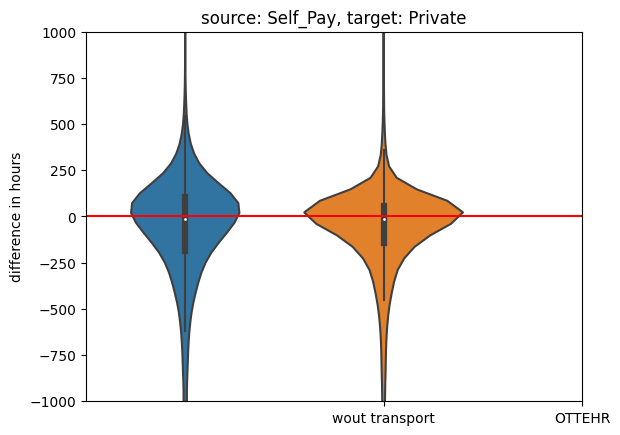

source is: Self_Pay, target is: Government


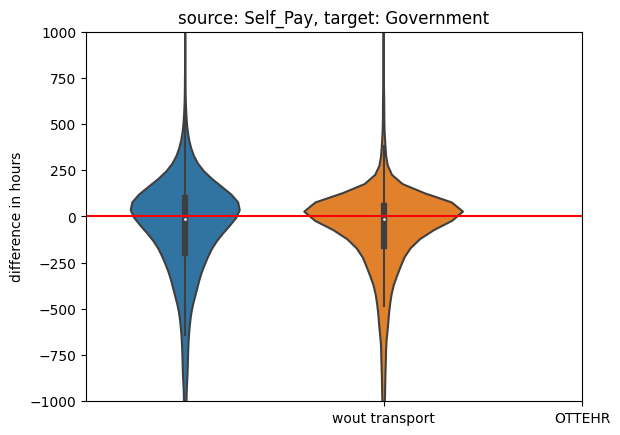

source is: Self_Pay, target is: Medicare


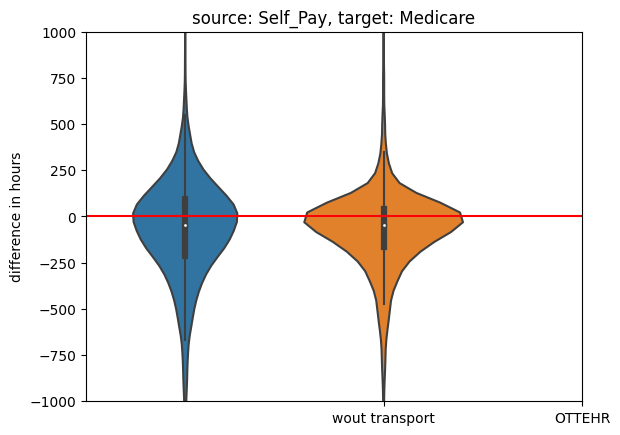

source is: Self_Pay, target is: Medicaid


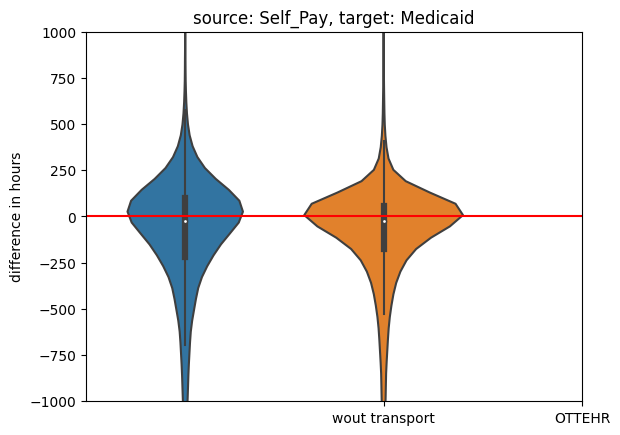

source is: Private, target is: Self_Pay


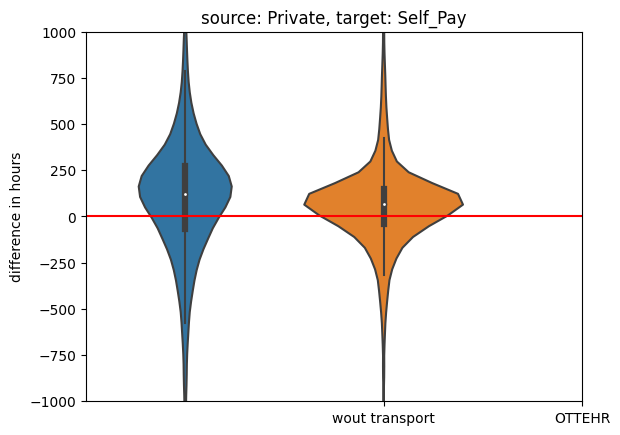

source is: Private, target is: Government


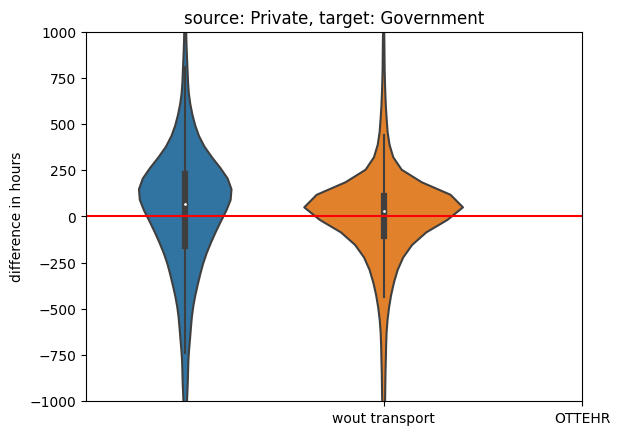

source is: Private, target is: Medicare


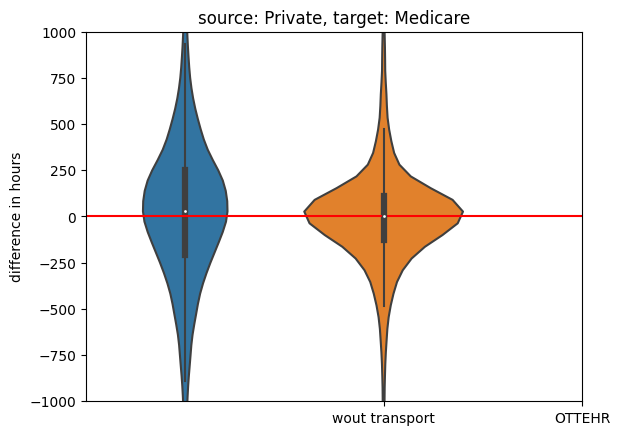

source is: Private, target is: Medicaid


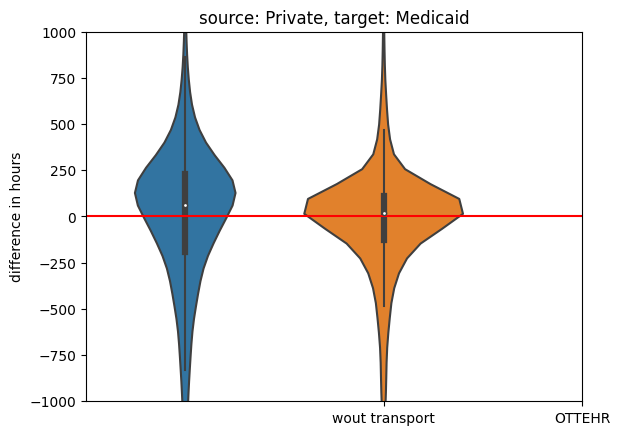

source is: Government, target is: Self_Pay


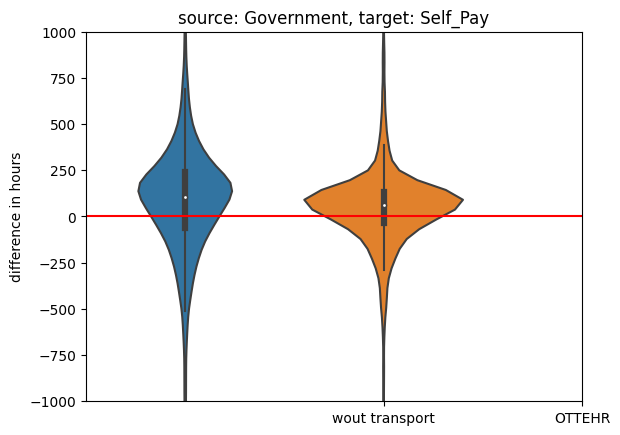

source is: Government, target is: Private


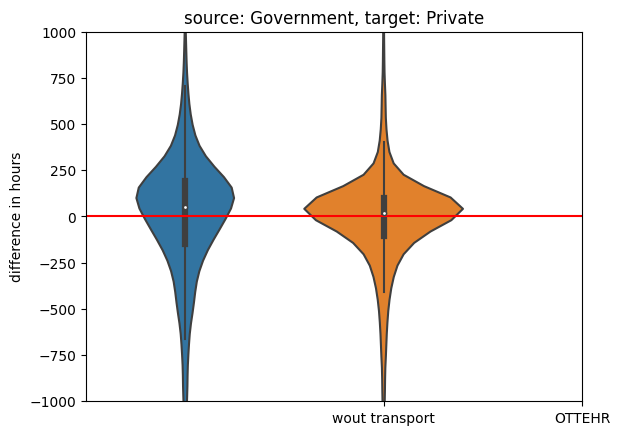

source is: Government, target is: Medicare


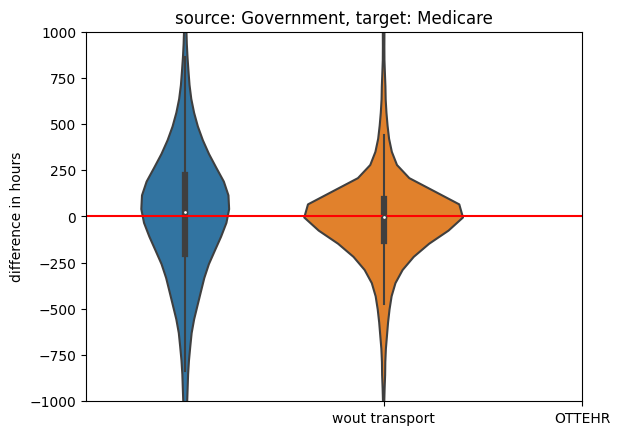

source is: Government, target is: Medicaid


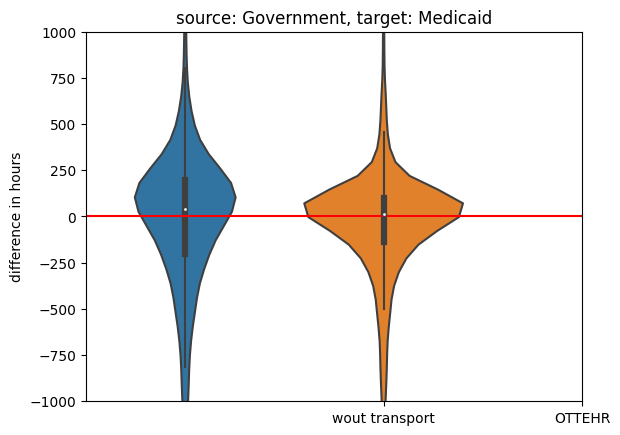

source is: Medicare, target is: Self_Pay


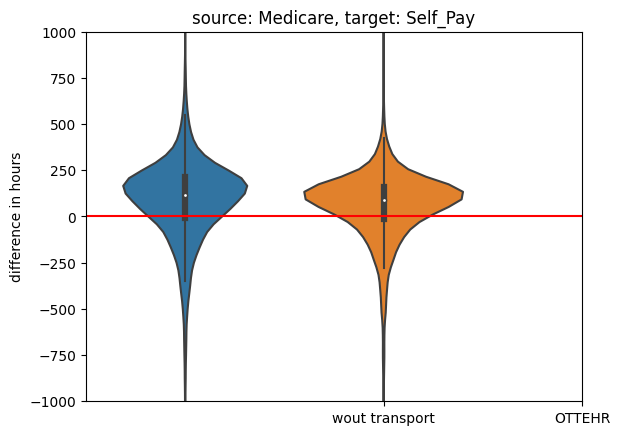

source is: Medicare, target is: Private


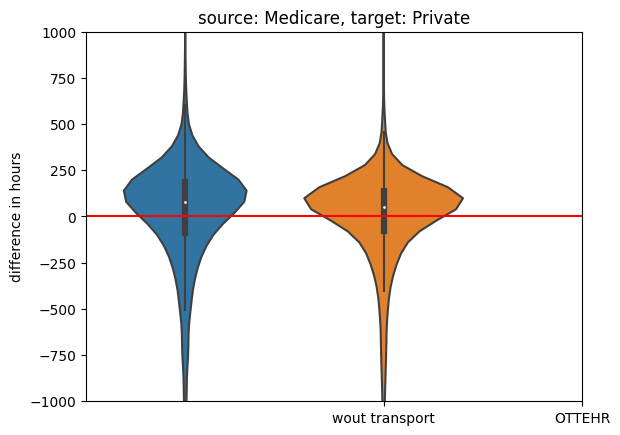

source is: Medicare, target is: Government


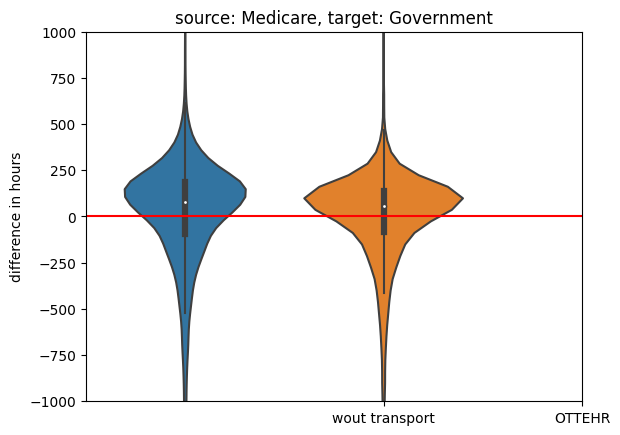

source is: Medicare, target is: Medicaid


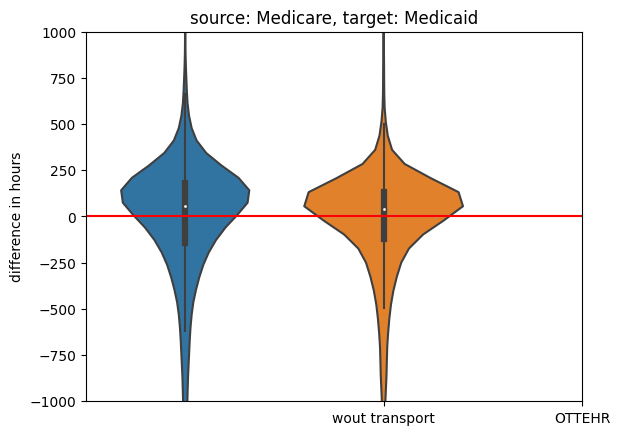

source is: Medicaid, target is: Self_Pay


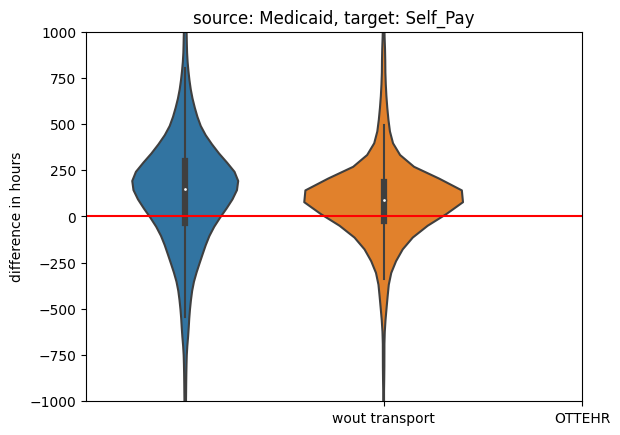

source is: Medicaid, target is: Private


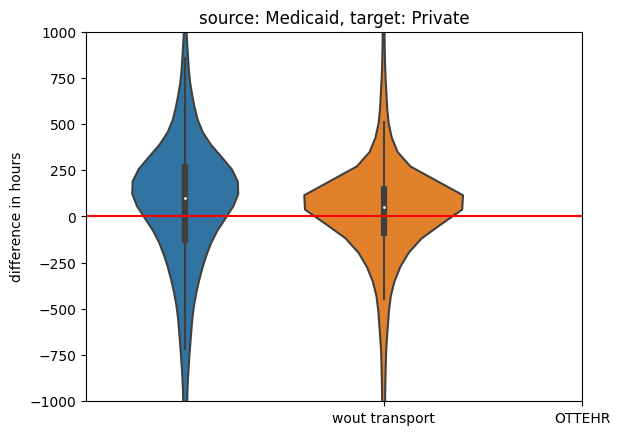

source is: Medicaid, target is: Government


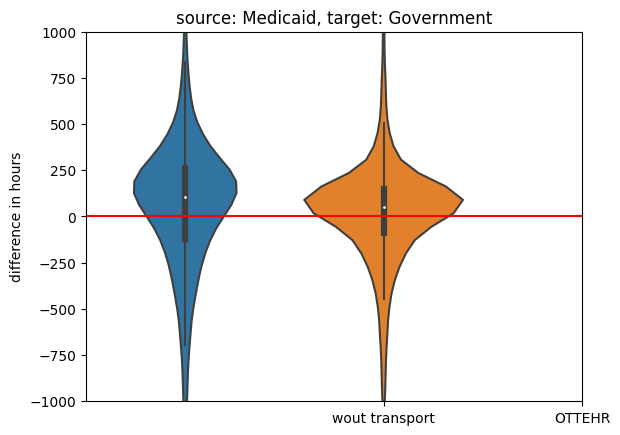

source is: Medicaid, target is: Medicare


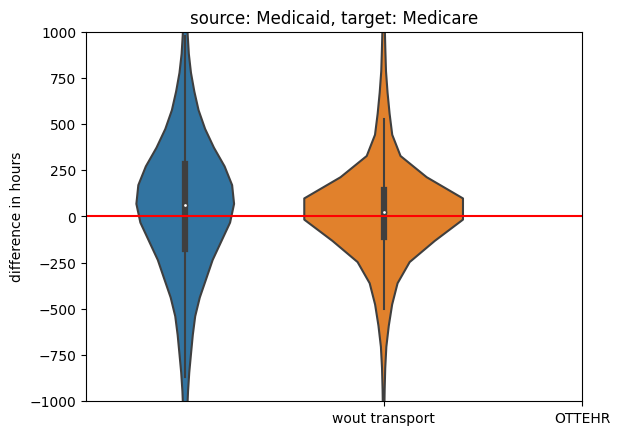

In [19]:
# Plot the violin plot for the differences between (1) target pred label - target label and (2) transported target pred label - target label and
for source_group in groups:
    for target_group in groups:
        if source_group == target_group:
            continue
        print(f"source is: {source_group}, target is: {target_group}")

        target_label, target_pred_label, trans_target_pred_label = read_df(group_name, source_group, target_group, trans_metric, log=False)
        target_label = [convert_sec2hour(x) for x in target_label]
        target_pred_label = [convert_sec2hour(x) for x in target_pred_label]
        trans_target_pred_label = [convert_sec2hour(x) for x in trans_target_pred_label]
        plt.figure()
        plt.title(f"source: {source_group}, target: {target_group}")
        sns.violinplot([np.array(target_pred_label)-np.array(target_label), np.array(trans_target_pred_label)-np.array(target_label)], showmedians=True)
        plt.ylabel('difference in hours')
        labels = ['wout transport', 'OTTEHR']
        plt.ylim(-1000, 1000)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xticks(range(1, len(labels)+1), labels=labels)
        plt.savefig(os.path.join(mimic_output_dir, f"{target_group}2{source_group}_duration_diff.pdf"), bbox_inches='tight')
        plt.show()


source is: Self_Pay, target is: Medicaid
source is: Private, target is: Medicaid
source is: Government, target is: Medicaid
source is: Medicare, target is: Medicaid


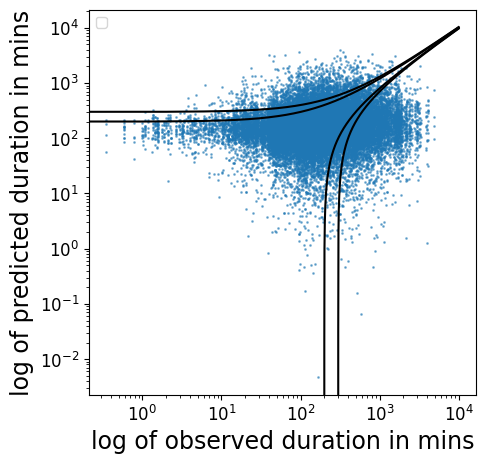

In [20]:
target_group = 'Medicaid'

plt.figure(figsize=(5,5))
ax = plt.gca()
for i, source_group in enumerate(groups):
    if source_group == target_group:
        continue

    print(f"source is: {source_group}, target is: {target_group}")
    
    target_label, target_pred_label, trans_target_pred_label = read_df(group_name, source_group, target_group, trans_metric, log=False)
    target_label = [convert_sec2hour(x) for x in target_label]
    trans_target_pred_label = [convert_sec2hour(x) for x in trans_target_pred_label]
    ax.scatter(target_label, trans_target_pred_label, s=1, alpha=0.5, c='tab:blue')
    # ax.scatter(target_label, target_pred_label, s=1, alpha=0.5, color=f"C{j}", label=group_2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('log of observed duration in mins', fontsize=17)
ax.set_ylabel('log of predicted duration in mins', fontsize=17)

#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels)
# tick_pos = [10**0, 10**1, 10**2, 10**3, 10**4, 2*10**4, 3*10**4, 10**5, 10**6]
# tick_labels = ['1e0', '1e1', '1e2', '1e3', '1e4', '2e4', '3e4', '1e5', '1e6']
# plt.xticks(tick_pos, tick_labels,  rotation = 45)
# plt.yticks(tick_pos, tick_labels)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)



x = np.linspace(0, 10**4, 10**4)
for thres in thresholds:
    y = x + thres
    plt.plot(x, y, c='black') # plot boundary to determine outliers

    y = x - thres
    plt.plot(x, y, c='black') # plot boundary to determine outliers
plt.savefig(os.path.join(mimic_output_dir, f"{target_group}_duration_diff.png"), bbox_inches='tight')
 

['Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private', 'Private'

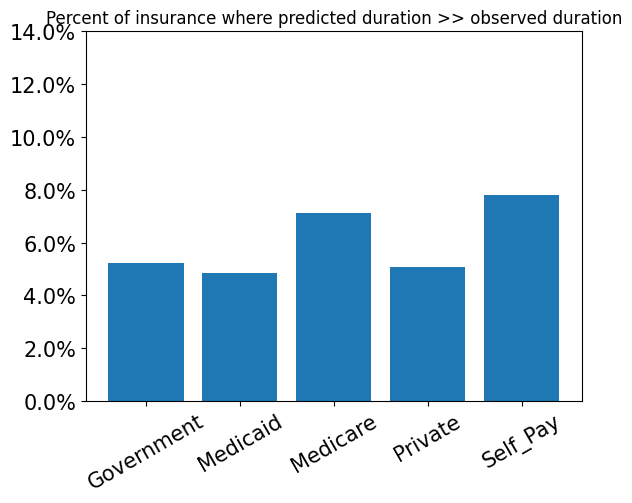

In [21]:
# Zoom in points that are outliers of the subset whose predicted duration >> observed duration 
plans = []
density_mat = np.zeros(shape=(len(groups), len(groups)))
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label, trans_target_pred_label = read_df(group_name, group_1, group_2, trans_metric, log=False)
        target_label = [convert_sec2hour(x) for x in target_label]
        trans_target_pred_label = [convert_sec2hour(x) for x in trans_target_pred_label]
        count = 0
        for x, y in zip(target_label, trans_target_pred_label):
            if y > x+thres  and y > 0:
                plans.append(group_2)
                count += 1
        density_mat[i, j] = count/len(target_label)

print(plans)
unique_values, counts = zip(*sorted(Counter(plans).items()))
target_label, target_pred_label, trans_target_pred_label = read_df(group_name, group_1, group_2, trans_metric, log=False)
print(len(target_label))
counts = [x/(len(target_label)*(len(groups)-1)) for x in counts]
print(counts)
ret = plt.bar(unique_values, counts)
plt.ylim(0, 0.14)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(rotation=30)

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.title(f"Percent of {group_name} where predicted duration >> observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_longer_predicted_duration_histogram.pdf'), bbox_inches='tight')


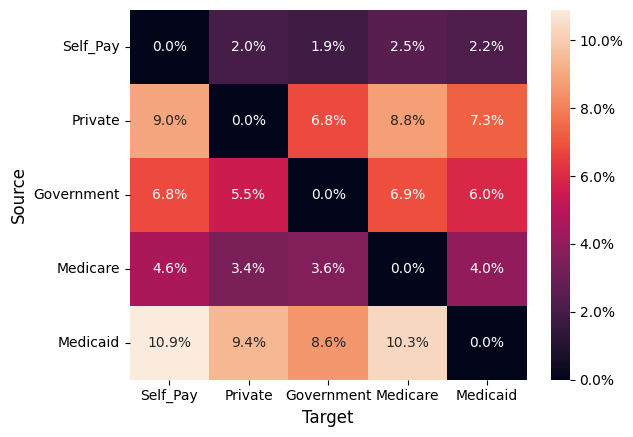

In [22]:
# Plot heatmap for the admissions with significantly longer predicted durations
df = pd.DataFrame(density_mat, columns = groups, index = groups)
ax = sns.heatmap(df, annot=True, fmt='.1%')
# for t in ax.texts: t.set_text(t.get_text() + " %")
plt.ylabel('Source', fontsize=12)
plt.xlabel('Target', fontsize=12)
cbar = ax.collections[0].colorbar

# Define a custom formatter function
formatter = ticker.FuncFormatter(lambda x, _: f'{100*x:.1f}%')

# Set the formatter for the color bar ticks
cbar.ax.yaxis.set_major_formatter(formatter)

plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_longer_predicted_duration_heatmap.pdf'), bbox_inches='tight')

[0.110225, 0.138975, 0.0945, 0.106775, 0.045325]


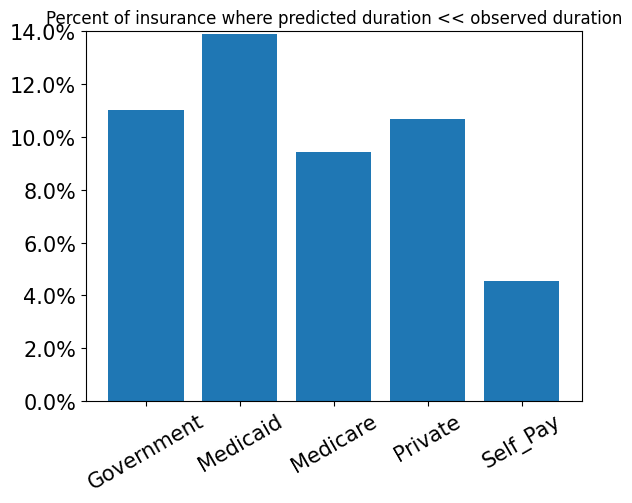

In [23]:
plans = []
density_mat = np.zeros(shape=(len(groups), len(groups)))

for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label, trans_target_pred_label = read_df(group_name, group_1, group_2, trans_metric, log=False)
        target_label = [convert_sec2hour(x) for x in target_label]
        trans_target_pred_label = [convert_sec2hour(x) for x in trans_target_pred_label]
        count = 0
        for x, y in zip(target_label, trans_target_pred_label):
            if y < x-thres  and y > 0:
                plans.append(group_2)
                count += 1
        density_mat[i, j] = count/len(target_label)

unique_values, counts = zip(*sorted(Counter(plans).items()))
counts = [x/(len(target_label)*(len(groups)-1)) for x in counts]
print(counts)
plt.bar(unique_values, counts)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xticks(rotation=30)
plt.ylim(0, 0.14)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.title(f"Percent of {group_name} where predicted duration << observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_shorter_predicted_duration_histogram.pdf'), bbox_inches='tight')



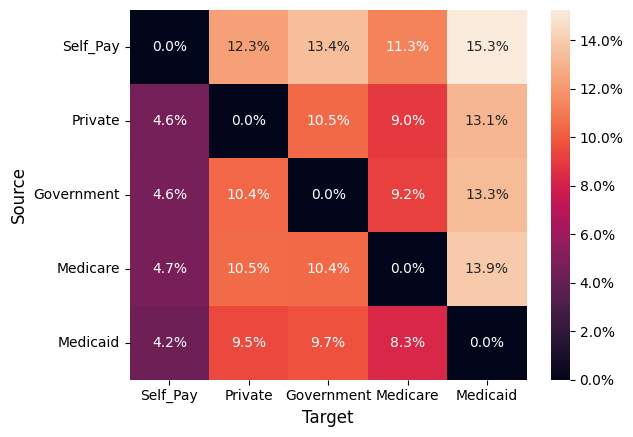

In [24]:
# Plot heatmap for the admissions with significantly shorter predicted durations
df = pd.DataFrame(density_mat, columns = groups, index = groups)
ax = sns.heatmap(df, annot=True, fmt='.1%')
# for t in ax.texts: t.set_text(t.get_text() + " %")
plt.ylabel('Source', fontsize=12)
plt.xlabel('Target', fontsize=12)
cbar = ax.collections[0].colorbar

# Define a custom formatter function
formatter = ticker.FuncFormatter(lambda x, _: f'{100*x:.1f}%')

# Set the formatter for the color bar ticks
cbar.ax.yaxis.set_major_formatter(formatter)

plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_shorter_predicted_duration_heatmap.pdf'), bbox_inches='tight')
